In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import math
from random import randint
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torch.nn.functional as F
from torchvision import models
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from scipy import ndimage
from scipy.ndimage.filters import convolve
from scipy import misc
import scipy.misc as sm
import cv2
from skimage.feature import canny
from IPython.display import HTML
from tqdm import tqdm_notebook
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/
device = 'cuda'
torch.cuda.manual_seed(7)
torch.manual_seed(7)
np.random.seed(7)
torch.cuda.empty_cache()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive


In [0]:
##### Coach Network #####

class coach_network(nn.Module):
  def __init__(self, drop_ratio = 0.5):
    super(coach_network,self).__init__()
    model = models.resnet18()
    self.layer1 = torch.nn.Sequential(*(list(model.children())[:2]))
    self.layer2 = torch.nn.Sequential(*(list(model.children())[4:-2]))
    self.drop_ratio = drop_ratio
    self.mu = nn.Conv2d(512,100,kernel_size = 1)
    self.std = nn.Conv2d(512,100,kernel_size = 1)
    self.pred = nn.Conv2d(100,1,kernel_size = 1)
    self.upsample = nn.Upsample(scale_factor=16, mode = 'nearest')
    self.sigmoid = nn.Sigmoid()


    for m in self.modules():
        if isinstance(m, nn.Conv2d) and m is not self.mu and m is not self.std:
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()


  def reparametrize(self,mu,logvar):
    std = logvar.mul_(0.5).exp_()
    eps = Variable(std.data.new(std.size()).normal_())
    return eps.mul(std).add_(mu)


  def get_features(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    mu = self.mu(x)
    logvar = self.std(x)
    z = self.reparametrize(mu,logvar)
    d = self.pred(z)

    return d,mu,logvar

  
  def forward(self, x, alpha, use_coach = True):
    features = None
    mu = None
    logvar = None

    if not use_coach:
      size_ = x.size()
      features = Variable(torch.rand(size_[0], 1, int(size_[2]/16), int(size_[3]/16)).cuda())
    
    else:
      features,mu,logvar = self.get_features(x)

    size_ = features.size()
    features = features.view(size_[0], size_[1], size_[2]*size_[3])
    p,_ = features.topk(k = int(size_[2]*size_[3]*self.drop_ratio), dim = 2)
    partitions = p[:,:, -1]
    partitions = partitions.unsqueeze(2).expand(size_[0], size_[1], size_[2]*size_[3])
    mask = self.sigmoid(alpha*(features - partitions))


    mask = mask.view(size_)

    if not self.training:
        mask = (mask>0.5).float()

    mask = self.upsample(mask)

    return mask, mu, logvar


##### Inpainting Model #####

class inpainting_network(nn.Module):
  def __init__(self):
    super(inpainting_network,self).__init__()
    model = models.resnet18()
    self.encoder = torch.nn.Sequential(*(list(model.children())[:-2]))
    self.relu = nn.ReLU(inplace = True)
    
    self.deconv1 = nn.ConvTranspose2d(512,512,4,2,padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(512)
    
    self.deconv2 = nn.ConvTranspose2d(512,256,4,2,padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(256)

    self.deconv3 = nn.ConvTranspose2d(256,128,4,2,padding = 1, bias = False)
    self.bn3 = nn.BatchNorm2d(128)

    self.deconv4 = nn.ConvTranspose2d(128,64,4,2,padding = 1, bias = False)
    self.bn4 = nn.BatchNorm2d(64)

    self.deconv5 = nn.ConvTranspose2d(64,32,4,2,padding = 1, bias = False)
    self.bn5 = nn.BatchNorm2d(32)

    self.regressor = nn.ConvTranspose2d(32,3,3,1,padding = 1, bias = True)
    self.tanh = nn.Tanh()

    for m in self.modules():
          if isinstance(m, nn.Conv2d):
              n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
              m.weight.data.normal_(0, math.sqrt(2. / n))
              if m.bias is not None:
                  m.bias.data.normal_(0, math.sqrt(2. / n))
          elif isinstance(m, nn.BatchNorm2d):
              m.weight.data.fill_(1)
              m.bias.data.zero_()


  def forward(self,x):
    x = self.encoder(x)
    
    x = self.deconv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.deconv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    x = self.deconv3(x)
    x = self.bn3(x)
    x = self.relu(x)

    x = self.deconv4(x)
    x = self.bn4(x)
    x = self.relu(x)

    x = self.deconv5(x)
    x = self.bn5(x)
    x = self.relu(x)

    x = self.regressor(x)
    x = self.tanh(x)
    
    return x

In [0]:
def gram_matrix(image):

  b,ch, h, w = image.size()
  f = image.view(b,ch, w * h)
  f_T = f.transpose(1,2)
  G = f.bmm(f_T) / (h * w * ch)

  return G

In [0]:
train_dataset = dset.VOCSegmentation('VOC_train')

In [0]:
val_dataset = dset.VOCSegmentation('VOC_val')

In [0]:
class voc_dataset(torch.utils.data.Dataset):
  def __init__(self, dataset,erase_shape = [16,16], erase_count = 16):
    self.mean_bgr = np.array([0.4568, 0.4431, 0.4083])
    self.std_bgr = np.array([0.2676, 0.2641, 0.2680])
    self.dataset = dataset
    self.erase_shape = erase_shape
    self.erase_count = erase_count

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self,index):
    image,mask = self.dataset.__getitem__(index)
    
    image = image.resize((256,256))
    image = np.array(image)

    mask = mask.resize((256,256))
    mask = np.array(mask)
    mask = mask.reshape((256,256,1))
    mask = np.repeat(mask, 3, axis = 2)
    mask = mask/255
    mask = mask > 0
    mask = mask.astype(np.float)
    mask = 1.0 - mask

 ## Flip the image with prob = 0.5 
    flip = torch.LongTensor(1).random_(0,2)[0]*2 - 1
    image = image[:, ::flip, :]
    mask = mask[:, ::flip, :]

## Rotate the image randomly
    choice = torch.LongTensor(1).random_(0,4)[0]
    angles = [0, 90, 180, 270]
    angle = angles[choice]
    center = tuple(np.array(image.shape)[:2]/2)
    rot_mat = None
    rot_mat = cv2.getRotationMatrix2D(center,angle,1)
    image = cv2.warpAffine(image, rot_mat, image.shape[:2], flags = cv2.INTER_LINEAR)
    mask = cv2.warpAffine(mask, rot_mat, mask.shape[:2], flags = cv2.INTER_LINEAR)
    if self.erase_count == 1:                             ### erase a patch in the center of image
        offset = (image.shape[0] - erase_shape[0])/2
        end = offset+erase_shape[0]
        mask[offset:end, offset:end, :] = 0
        
    else:   
        for c_ in range(self.erase_count):
            row = torch.LongTensor(1).random_(0, image.shape[0]-self.erase_shape[0]-1)[0]
            col = torch.LongTensor(1).random_(0, image.shape[1]-self.erase_shape[1]-1)[0]
            
            mask[row:row+self.erase_shape[0], col:col+self.erase_shape[1], :] = 0

    input_, mask, target = self.transform(image,mask)

    return input_, mask, target

  def transform(self, image, mask):
    image = image/255
    image = image.astype(np.float64)
    image -= self.mean_bgr
            
    input_ = image.copy()                        
    
    image[:,:,0] /= 3*self.std_bgr[0]
    image[:,:,1] /= 3*self.std_bgr[1]
    image[:,:,2] /= 3*self.std_bgr[2]

    index_ = image > 1
    image[index_] = 1
    index_ = image < -1
    image[index_] = -1
    image = image.transpose(2, 0, 1)
    image = torch.from_numpy(image.copy()).float()
    
    input_ = input_.transpose(2, 0, 1)
    input_ = torch.from_numpy(input_.copy()).float()                        
    
    mask = mask.transpose(2, 0, 1)
    mask = torch.from_numpy(mask.copy())                        

    return input_, mask, image

In [0]:
erase_shape = [16,16]
erase_count = 16

In [0]:
train_loader = torch.utils.data.DataLoader(voc_dataset(dataset = train_dataset, erase_shape = erase_shape, erase_count = erase_count), batch_size = 32, shuffle = True, num_workers = 1)


val_loader = torch.utils.data.DataLoader(voc_dataset(dataset = val_dataset, erase_shape = erase_shape, erase_count = erase_count),batch_size = 16, num_workers = 1, shuffle = False)

In [0]:
mean_bgr = np.array([0.4568, 0.4431, 0.4083])
std_bgr = np.array([0.2676, 0.2641, 0.2680])

In [0]:
checkpoints = torch.load('model.ckpt.t7')
coach_net = checkpoints['coach']
inpainting_net = checkpoints['inpainting_net']

use_coach = True
coach_optimizer = None
inpainting_optimizer = None
best_loss = 1e5
train_loss = []
val_loss = []
coach_loss = []
rec_weight = 0.99

In [0]:
def train_inpainting(epoch, inpainting_net, inpainting_optimizer, coach = None, use_coach_masks = False):
  inpainting_net.train()
  
  if coach is not None:
    coach.eval()

  train_loss.append(0)

  for batch_idx, (inputs_, masks, targets) in enumerate(train_loader):
    inpainting_optimizer.zero_grad()
    targets = inputs_
    inputs_, masks, targets = Variable(inputs_.to(device)), Variable(masks.to(device)), Variable(targets.to(device))

    if coach is not None:
      masks, _, _ = coach.forward(inputs_,alpha = 1.0, use_coach = use_coach_masks)
    
    outputs_1 = inpainting_net(masks*inputs_)
    mse_loss = (outputs_1 - targets)**2
    mse_loss = (-1*F.threshold(-1*mse_loss, -2, -2))
    loss_rec = torch.sum(mse_loss*(1 - masks))/torch.sum(1 - masks)

    if coach is not None:
      loss_con = torch.sum(mse_loss * masks)/torch.sum(masks)
    else:
      outputs_2 = inpainting_net(inputs_*(1- masks))
      mse_loss = (outputs_2 - targets)**2
      mse_loss = -1*F.threshold(-1*mse_loss, -2, -2)
      loss_con = (torch.sum(mse_loss*masks)/torch.sum(masks))

    total_loss = rec_weight*loss_rec + (1-rec_weight)*loss_con
    total_loss.backward()

    net_optimizer.step()

    train_loss[-1] = train_loss[-1] + total_loss.data
    print('Train (loss=%.4f)' % (train_loss[-1]/(batch_idx+1)))
  train_loss[-1] = train_loss[-1]/len(train_loader)


def train_coach(epoch, inpainting_net, coach_net, coach_optimizer):
  coach_net.train()
  inpainting_net.eval()
  coach_loss.append(0)

  for batch_idx, (inputs_, masks, targets) in enumerate(train_loader):
    coach_optimizer.zero_grad()
    inputs_, targets = Variable(inputs_.to(device)), Variable(targets.to(device))

    masks, mu, logvar = coach_net.forward(inputs_, alpha = 1)

    outputs = inpainting_net(inputs_*masks).detach()
    mse_loss = (outputs - targets)**2
    mse_loss = -1*F.threshold(-1*mse_loss, -2, -2)
    loss_rec = torch.sum(mse_loss*(1 - masks))/torch.sum(1 - masks)

    mu = mu.mean(dim = 2).mean(dim = 2)
    logvar = logvar.mean(dim = 2).mean(dim = 2)

    KLD = 0 
    try:
      KLD = -0.5*torch.sum(1+logvar - mu**2 - logvar.exp())
    except:
      KLD = 0

    total_loss = 1 - loss_rec + 1e-6*KLD

    total_loss.backward()
    coach_optimizer.step()

    coach_loss[-1] = coach_loss[-1] + total_loss.data
    print('Coach (loss = %.4f)' % (coach_loss[-1]/(batch_idx+1)))
  coach_loss[-1] = coach_loss[-1]/len(train_loader)


def val_inpainting(iter_, epoch, inpainting_net, coach = None, use_coach_masks = False):
  global best_loss
  inpainting_net.eval()

  if coach is not None:
    coach.eval()
  
  val_loss.append(0)
  for batch_idx, (inputs_, masks, targets) in enumerate(val_loader):
    inputs_, masks, targets = Variable(inputs_.cuda()), Variable(masks.cuda().float()), Variable(targets.cuda())

    if coach is not None:
      masks, _, _ = coach.forward(inputs_, alpha = 100, use_coach = use_coach_masks)

    outputs_1 = inpainting_net(inputs_*masks)
    mse_loss = (targets - outputs_1)**2
    mse_loss = (-1*F.threshold(-1*mse_loss, -2, -2))
    loss_rec = (torch.sum(mse_loss * (1 - masks))/torch.sum(1 - masks))

    outputs_2 = inpainting_net(inputs_*(1 - masks))
    mse_loss = (targets - outputs_2)**2
    mse_loss = (-1*F.threshold(-1*mse_loss, -2, -2))
    loss_con = (torch.sum(mse_loss*masks)/torch.sum(masks))

    total_loss = (rec_weight*loss_rec + (1 - rec_weight)*loss_con)

    val_loss[-1] = (val_loss[-1] + total_loss.data)
    print('Val (loss= %.4f)' % (val_loss[-1]/(batch_idx+1)))

  val_loss[-1] = (val_loss[-1]/len(val_loader))

  if best_loss > val_loss[-1]:
    best_loss = val_loss[-1]
    print('Saving...')
    state = {'inpainting_net' : inpainting_net, 'coach' : coach}

    torch.save(state, 'bmvc2018' + str(iter_) + '.ckpt.t7')

In [0]:
use_coach_masks = False
epochs = []
lrs = []

if use_coach:
    epochs = [100, 30, 30, 30, 30, 30]
    lrs = [[1e-1, 1e-2, 1e-3, 1e-4],
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5],
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5], 
       [1e-5, 1e-5, 1e-5, 1e-5]]
else:
    epochs = [100]
    lrs = [[1e-1, 1e-2, 1e-3, 1e-4]]

In [14]:
for iter_ in range(1, len(epochs)):
    best_loss = 1e5    
    
    if use_coach and iter_ > 0:
        use_coach_masks = True
        
        optimizer_coach = optim.Adam(coach_net.parameters(), lr=1e-5)
        
        for epoch in range(epochs[iter_]):
            train_coach(epoch, inpainting_net=inpainting_net, coach_net=coach_net, coach_optimizer=optimizer_coach)
        
    
    net_optimizer = optim.SGD(inpainting_net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    
    for epoch in range(epochs[iter_]):               
        if epoch == 90:
            net_optimizer = optim.SGD(inpainting_net.parameters(), lr=lrs[iter_][3], momentum=0.9, weight_decay=5e-4)
        if epoch == 80:
            net_optimizer = optim.SGD(inpainting_net.parameters(), lr=lrs[iter_][2], momentum=0.9, weight_decay=5e-4)
        if epoch == 40:
            net_optimizer = optim.SGD(inpainting_net.parameters(), lr=lrs[iter_][1], momentum=0.9, weight_decay=5e-4)
        if epoch == 0:
            net_optimizer = optim.SGD(inpainting_net.parameters(), lr=lrs[iter_][0], momentum=0.9, weight_decay=5e-4)
    
        train_inpainting(epoch, inpainting_net = inpainting_net, inpainting_optimizer=net_optimizer, coach=coach_net, use_coach_masks=use_coach_masks)
        val_inpainting(iter_, epoch, inpainting_net = inpainting_net, coach=coach_net, use_coach_masks=use_coach_masks)
        print('Epochs: %d/%d' % (epoch, epochs[iter_]))

Coach (loss = 0.6736)
Coach (loss = 0.6747)
Coach (loss = 0.6935)
Coach (loss = 0.6845)
Coach (loss = 0.6781)
Coach (loss = 0.6850)
Coach (loss = 0.6866)
Coach (loss = 0.6870)
Coach (loss = 0.6895)
Coach (loss = 0.6866)
Coach (loss = 0.6854)
Coach (loss = 0.6856)
Coach (loss = 0.6879)
Coach (loss = 0.6857)
Coach (loss = 0.6834)
Coach (loss = 0.6820)
Coach (loss = 0.6808)
Coach (loss = 0.6797)
Coach (loss = 0.6820)
Coach (loss = 0.6794)
Coach (loss = 0.6783)
Coach (loss = 0.6783)
Coach (loss = 0.6785)
Coach (loss = 0.6762)
Coach (loss = 0.6784)
Coach (loss = 0.6785)
Coach (loss = 0.6781)
Coach (loss = 0.6788)
Coach (loss = 0.6791)
Coach (loss = 0.6776)
Coach (loss = 0.6772)
Coach (loss = 0.6783)
Coach (loss = 0.6796)
Coach (loss = 0.6796)
Coach (loss = 0.6802)
Coach (loss = 0.6804)
Coach (loss = 0.6794)
Coach (loss = 0.6801)
Coach (loss = 0.6807)
Coach (loss = 0.6804)
Coach (loss = 0.6800)
Coach (loss = 0.6798)
Coach (loss = 0.6806)
Coach (loss = 0.6811)
Coach (loss = 0.6828)
Coach (los

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type inpainting_network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type coach_network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Streaming output truncated to the last 5000 lines.
Coach (loss = 0.7311)
Coach (loss = 0.7317)
Coach (loss = 0.7306)
Coach (loss = 0.7331)
Coach (loss = 0.7335)
Coach (loss = 0.7314)
Coach (loss = 0.7326)
Coach (loss = 0.7335)
Coach (loss = 0.7342)
Coach (loss = 0.7348)
Coach (loss = 0.7355)
Coach (loss = 0.7380)
Coach (loss = 0.7377)
Coach (loss = 0.7386)
Coach (loss = 0.7395)
Coach (loss = 0.7385)
Coach (loss = 0.7400)
Coach (loss = 0.7397)
Coach (loss = 0.7390)
Coach (loss = 0.7391)
Coach (loss = 0.7373)
Coach (loss = 0.7381)
Coach (loss = 0.7378)
Coach (loss = 0.7362)
Coach (loss = 0.7358)
Coach (loss = 0.7364)
Coach (loss = 0.7371)
Coach (loss = 0.7376)
Coach (loss = 0.7376)
Coach (loss = 0.7370)
Coach (loss = 0.7360)
Coach (loss = 0.7362)
Coach (loss = 0.7360)
Coach (loss = 0.7360)
Coach (loss = 0.7365)
Coach (loss = 0.7363)
Coach (loss = 0.7370)
Coach (loss = 0.7367)
Coach (loss = 0.7370)
Coach (loss = 0.7255)
Coach (loss = 0.7091)
Coach (loss = 0.7075)
Coach (loss = 0.7099)
Coa

In [0]:
real_cpu = next(iter(val_loader))

In [0]:
input_ = real_cpu[0][6].cuda()
mask = real_cpu[1][6].cuda()
target = real_cpu[2][6].cuda()

In [0]:
checkpoints = torch.load('bmvc20185.ckpt.t7')
inpainting_net = checkpoints['inpainting_net']
coach = checkpoints['coach']

In [0]:
def display_image(image, mask, net):
  mean_bgr = np.array([0.4568, 0.4431, 0.4083])
  image1 = image.cpu()
  input1 = image*mask
  input1 = input1.unsqueeze_(0)
  input1 = input1.float()
  output = net(input1)
  output = output.squeeze_(0)
  output = output.cpu()
  output = output.detach().numpy()
  input1 = input1.squeeze_(0)
  input1 = input1.cpu()
  input1 = input1.detach().numpy()
  mean = mean_bgr.reshape(3,1,1)
  output1 = output + mean
  input2 = input1 + mean
  mask = mask.cpu()
  plt.imshow(np.transpose(input1, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


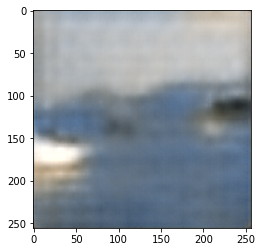

In [52]:
mask = torch.ones((256,256,3)).cuda()

for c_ in range(16):
    row = torch.LongTensor(1).random_(0, 256-16-1)[0]
    col = torch.LongTensor(1).random_(0, 256-16-1)[0]
    
    mask[row:row+16, col:col+16, :] = 0

mask = mask.reshape(3,256,256)

display_image(input_, mask, inpainting_net)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


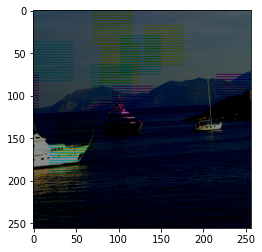

In [54]:
mask = torch.ones((256,256,3)).cuda()

for c_ in range(16):
    row = torch.LongTensor(1).random_(0, 256-16-1)[0]
    col = torch.LongTensor(1).random_(0, 256-16-1)[0]
    
    mask[row:row+16, col:col+16, :] = 0

mask = mask.reshape(3,256,256)

display_image(input_, mask, inpainting_net)

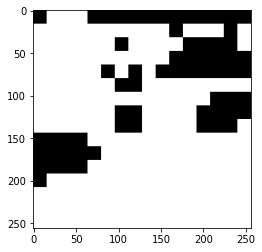

In [77]:
input_ = real_cpu[0][6].cuda()
mask = real_cpu[1][6].cuda()
target = real_cpu[2][6].cuda()

mask,_,_ = coach.forward(input_.unsqueeze_(0), alpha = 1)
input1 = input_*mask
masked = mask.reshape(1,256,256)
masked = masked.squeeze_(0)
masked = masked.cpu()
masked = masked.detach().numpy()
plt.imshow(masked, 'gray')